# MNIST Image Classification - Python API

*We recommend using a GPU runtime for this example. In the Colab menu bar, choose **Runtime** > **Change Runtime Type** and choose **GPU** under Hardware Accelerator.*

In this notebook, we will show how to use the Ludwig Python API to:


1.   [Download a Dataset](#scrollTo=Download_Dataset)
2.   [Train a Ludwig Model](#scrollTo=Train)
3.   [Evaluate the trained model](#scrollTo=Evaluate)
4.   [Visualize training and test metrics](#scrollTo=Visualize_Metrics)
5.   [Make predictions on New Data](#scrollTo=Make_Predictions_on_New_Data)


In [1]:
# Prerequisite: Installs the latest version of Ludwig in the Colab environment
!python -m pip install git+https://github.com/ludwig-ai/ludwig.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 398 kB 5.3 MB/s 
     |████████████████████████████████| 47 kB 4.5 MB/s 
     |████████████████████████████████| 136 kB 50.1 MB/s 
     |████████████████████████████████| 1.1 MB 40.1 MB/s 
     |████████████████████████████████| 94 kB 1.1 MB/s 
     |████████████████████████████████| 144 kB 35.3 MB/s 
     |████████████████████████████████| 271 kB 29.2 MB/s 


# Download Dataset

MNIST is a collection of gray-scale images of hand-written digits.  This collection is made up of 60,000 images for training and 10,000 images for testing model performance.  

After downloading the the images, a single csv file is created in the working directory for this notebook.


This dataset contains two columns:

| column      | description                                                |
|-------------|------------------------------------------------------------|
| image_path  | File path string to an image. |
| label       | Integer variable indicating the image's digit (0, 1, 2, ..., 9) |

In [2]:
from ludwig.datasets import mnist

# Loads the dataset as a pandas.DataFrame
train_df, test_df, _ = mnist.load(split=True)

NumExpr defaulting to 2 threads.


train-images-idx3-ubyte.gz: 9.46MB [00:00, 41.4MB/s]                            
train-labels-idx1-ubyte.gz: 32.0kB [00:00, 869kB/s]
t10k-images-idx3-ubyte.gz: 1.58MB [00:00, 17.1MB/s]
t10k-labels-idx1-ubyte.gz: 8.00kB [00:00, 223kB/s]


>>> create ludwig formatted training data
>>> create ludwig formatted testing data
>>> completed data preparation


## Display sample training and test data

In [3]:
import pandas as pd
import numpy as np

# setup pandas output options
pd.set_option('display.max_colwidth', 80)

# make reproducible output sample
np.random.seed(31)

# Print sample of trainig and test data sets.
print(f"Training Dataset(train_df):\n{train_df.sample(n=5)}")
print(f"\nTest Dataset(test_df):\n{test_df.sample(n=5)}")

Training Dataset(train_df):
                                                         image_path  label
20948  /root/.ludwig_cache/mnist_1.0/processed/training/3/11233.png      3
56127  /root/.ludwig_cache/mnist_1.0/processed/training/9/28313.png      9
40804  /root/.ludwig_cache/mnist_1.0/processed/training/6/36810.png      6
31712  /root/.ludwig_cache/mnist_1.0/processed/training/5/39700.png      5
21173  /root/.ludwig_cache/mnist_1.0/processed/training/3/15377.png      3

Test Dataset(test_df):
                                                       image_path  label
68750  /root/.ludwig_cache/mnist_1.0/processed/testing/8/8726.png      8
69036  /root/.ludwig_cache/mnist_1.0/processed/testing/9/1165.png      9
67720  /root/.ludwig_cache/mnist_1.0/processed/testing/7/7523.png      7
62197  /root/.ludwig_cache/mnist_1.0/processed/testing/2/8966.png      2
65545  /root/.ludwig_cache/mnist_1.0/processed/testing/5/7511.png      5


# Display sample training images
## Helper function to display images

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

def plotDigitGrid(X,y,idxs,y_hat=None):
    plt.figure(figsize=(14,12))

    for i in range(len(idxs)):
        plt.subplot(5,6,i+1)
        
        if y_hat is None:
            plt.title('Label: {label}'.format(label=y[idxs[i]]))
        else:
            plt.title("Label: {label}  Pred: {pred}".format(label=y[idxs[i]], pred=y_hat[idxs[i]]))

        plt.imshow(X[idxs[i]], cmap='Greys')
        plt.tick_params(
            axis='both',          # changes apply to the x-axis and y-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # tick marks on bottom side are off
            left=False,        # tick marks on left side are off
            labelleft=False,   # label on left side are off
            labelbottom=False) # labels along the bottom edge are off
        plt.subplots_adjust(hspace=0.5)

    plt.show()

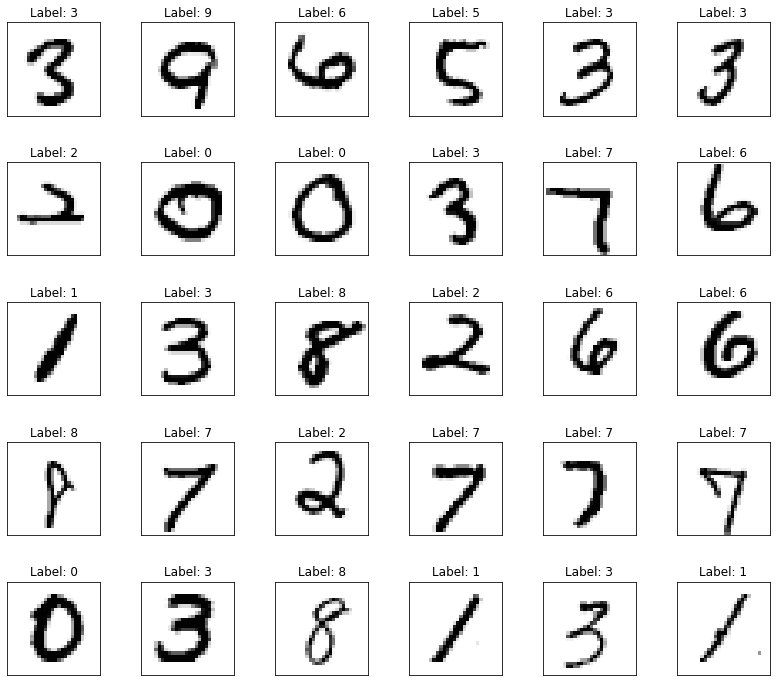

In [5]:
# retrieve sample of 30 training images to display
np.random.seed(31)
sample_df = train_df.sample(n=30)

# add image array to sample dataframe
sample_df['image'] = sample_df['image_path'].apply(plt.imread)

# plot the sample images
plotDigitGrid(sample_df['image'], sample_df['label'], sample_df.index)

# Train

## Define ludwig config

The Ludwig config declares the machine learning task. It tells Ludwig what to predict, what columns to use as input, and optionally specifies the model type and hyperparameters.


In [6]:
config = {
  'input_features': [
    {
      'name': 'image_path', 
      'type': 'image', 
      'preprocessing': {'num_processes': 4}, 
      'encoder': 'stacked_cnn', 
      'conv_layers': [
        {'num_filters': 32, 'filter_size': 3, 'pool_size': 2, 'pool_stride': 2}, 
        {'num_filters': 64, 'filter_size': 3, 'pool_size': 2, 'pool_stride': 2, 'dropout': 0.4}
      ], 
     'fc_layers': [{'output_size': 128, 'dropout': 0.4}]
    }
  ], 
  'output_features': [{'name': 'label', 'type': 'category'}], 
  'trainer': {'epochs': 5}
}


## Create a model from config



In [7]:
import logging
from ludwig.api import LudwigModel

# Constructs Ludwig model from config dictionary
model = LudwigModel(config, logging_level=logging.INFO)

import ray failed with exception: No module named 'ray'


## Train the model

In [8]:
# Trains the model. This cell might take a few minutes.
train_stats, preprocessed_data, output_directory = model.train(dataset=train_df)


╒════════════════════════╕
│ EXPERIMENT DESCRIPTION │
╘════════════════════════╛

╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ ludwig_version   │ '0.5rc2'                                                                                │
├──────────────────┼─────────

# Evaluate

In [9]:
# Generates predictions and performance statistics for the test set.
test_stats, predictions, output_directory = model.evaluate(
  test_df,
  collect_predictions=True,
  collect_overall_stats=True
)

Using in_memory = False is not supported with <class 'pandas.core.frame.DataFrame'> data format.
Evaluation: 100%|██████████| 79/79 [00:00<00:00, 132.46it/s]

===== label =====
accuracy: 0.9897000193595886
hits_at_k: 0.9995999932289124
loss: 0.03631824627518654
overall_stats: { 'avg_f1_score_macro': 0.9896561054793113,
  'avg_f1_score_micro': 0.9897,
  'avg_f1_score_weighted': 0.9897034336103594,
  'avg_precision_macro': 0.9896668422874528,
  'avg_precision_micro': 0.9897,
  'avg_precision_weighted': 0.9897,
  'avg_recall_macro': 0.9896709436539968,
  'avg_recall_micro': 0.9897,
  'avg_recall_weighted': 0.9897,
  'kappa_score': 0.9885511544921329,
  'token_accuracy': 0.9897}
per_class_stats: {<UNK>: {   'accuracy': 1.0,
    'f1_score': 0,
    'fall_out': 0.0,
    'false_discovery_rate': 1.0,
    'false_negative_rate': 1.0,
    'false_negatives': 0,
    'false_omission_rate': 0.0,
    'false_positive_rate': 0.0,
    'false_positives': 0,
    'hit_rate': 0,
    'informedness': 0.0,
    '

# Visualize Metrics

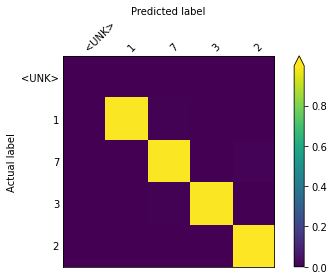

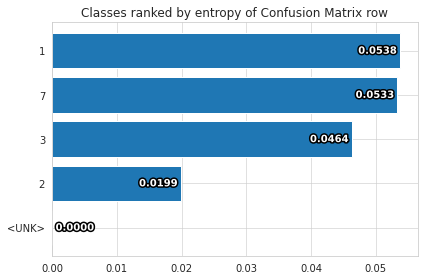

In [10]:
# Visualizes confusion matrix, which gives an overview of classifier performance
# for each class.
from ludwig.visualize import confusion_matrix

confusion_matrix(
  [test_stats],
  model.training_set_metadata,
  'class',
  top_n_classes=[5],
  model_names=[''],
  normalize=True,
)

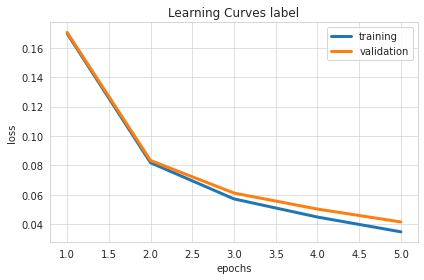

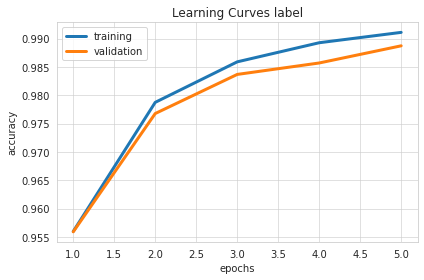

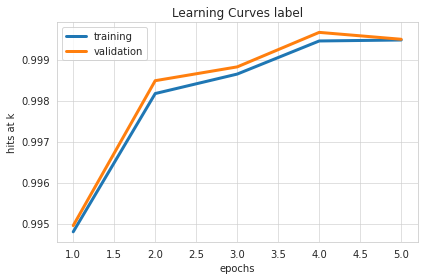

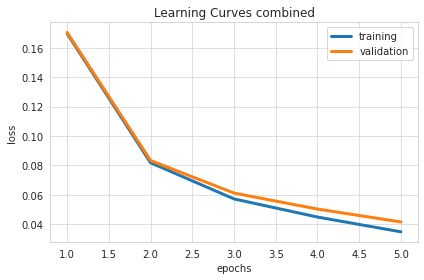

In [11]:
# Visualizes learning curves, which show how performance metrics changed over
# time during training.
from ludwig.visualize import learning_curves

learning_curves(train_stats, output_feature_name='class')

# Make Predictions on New Data

Lastly we'll show how to generate predictions for new data.

The following are some recent news headlines. Feel free to edit or add your own strings to text_to_predict to see how the newly trained model classifies them.

In [12]:
import pandas as pd

predictions, output_directory = model.predict(test_df)
predictions.index = test_df.index

predictions = pd.merge(test_df, predictions, left_index=True, right_index=True)

np.random.seed(321)
predictions.sample(n=10)

Using in_memory = False is not supported with <class 'pandas.core.frame.DataFrame'> data format.
Prediction: 100%|██████████| 79/79 [00:00<00:00, 455.69it/s]


,image_path,label,label_predictions,label_probabilities,label_probability,label_probabilities_<UNK>,label_probabilities_1,label_probabilities_7,label_probabilities_3,label_probabilities_2,label_probabilities_9,label_probabilities_0,label_probabilities_6,label_probabilities_8,label_probabilities_4,label_probabilities_5
63074,/root/.ludwig_cache/mnist_1.0/processed/testing/2/8318.png,2,2,"[1.4748856074220384e-06, 7.408981036860496e-05, 0.00021699647186324, 0.00059...",0.997162,1.474886e-06,7.408981e-05,2.169965e-04,5.969114e-04,9.971615e-01,3.545601e-05,3.174137e-05,2.573947e-06,0.001818,5.385318e-05,0.000007
62000,/root/.ludwig_cache/mnist_1.0/processed/testing/1/4105.png,1,1,"[2.0913847720294143e-07, 0.9965429902076721, 0.0010576042113825679, 1.936429...",0.996543,2.091385e-07,9.965430e-01,1.057604e-03,1.936430e-05,8.749774e-04,9.851874e-05,1.449148e-04,9.482301e-05,0.000278,8.527932e-04,0.000036
66604,/root/.ludwig_cache/mnist_1.0/processed/testing/6/9343.png,6,6,"[8.933811024292027e-09, 3.354279698442042e-08, 6.79895445498957e-11, 2.46542...",0.999893,8.933811e-09,3.354280e-08,6.798954e-11,2.465425e-08,1.890451e-06,1.517020e-08,9.907562e-06,9.998930e-01,0.000014,4.513249e-05,0.000036
61859,/root/.ludwig_cache/mnist_1.0/processed/testing/1/1214.png,1,1,"[7.3696955951163545e-06, 0.9799964427947998, 0.0015302429674193263, 6.247768...",0.979996,7.369696e-06,9.799964e-01,1.530243e-03,6.247769e-05,1.033600e-03,2.018212e-03,1.354826e-03,2.111893e-03,0.003567,7.643076e-03,0.000674
62170,/root/.ludwig_cache/mnist_1.0/processed/testing/2/4100.png,2,2,"[8.596455103315748e-08, 0.000150968277011998, 3.910665327566676e-06, 0.00722...",0.992498,8.596455e-08,1.509683e-04,3.910665e-06,7.228639e-03,9.924982e-01,6.259207e-07,8.475230e-08,7.796389e-09,0.000116,2.702195e-08,0.000001
61632,/root/.ludwig_cache/mnist_1.0/processed/testing/1/9171.png,1,1,"[2.953837793029379e-06, 0.9937723278999329, 0.00025632104370743036, 0.000106...",0.993772,2.953838e-06,9.937723e-01,2.563210e-04,1.068684e-04,6.975261e-04,2.448185e-04,2.258494e-04,5.820703e-04,0.002377,1.352682e-03,0.000382
66821,/root/.ludwig_cache/mnist_1.0/processed/testing/6/534.png,6,6,"[6.656635491708585e-07, 4.145693708323961e-07, 2.009524990853606e-09, 3.0323...",0.998295,6.656635e-07,4.145694e-07,2.009525e-09,3.032393e-06,6.010289e-05,6.125541e-07,3.172953e-05,9.982947e-01,0.000203,2.998140e-04,0.001106
65864,/root/.ludwig_cache/mnist_1.0/processed/testing/5/8571.png,5,5,"[2.8169369059583005e-08, 1.2092709056332751e-08, 1.8697170389714302e-07, 1.0...",0.999756,2.816937e-08,1.209271e-08,1.869717e-07,1.050272e-05,1.428119e-07,1.093132e-04,2.783798e-06,1.025338e-04,0.000018,1.890033e-07,0.999756
61198,/root/.ludwig_cache/mnist_1.0/processed/testing/1/8138.png,1,1,"[5.2596895727674564e-08, 0.9942867159843445, 3.861241202685051e-05, 8.844050...",0.994287,5.259690e-08,9.942867e-01,3.861241e-05,8.844050e-07,2.149036e-03,8.586155e-06,4.494158e-04,1.576425e-03,0.000750,7.218129e-04,0.000019
67878,/root/.ludwig_cache/mnist_1.0/processed/testing/7/5649.png,7,7,"[1.0918506632151548e-06, 6.311209290288389e-05, 0.9909278750419617, 1.105287...",0.990928,1.091851e-06,6.311209e-05,9.909279e-01,1.105287e-05,4.652595e-05,7.472397e-03,4.620137e-04,1.971343e-07,0.000017,9.851691e-04,0.000013


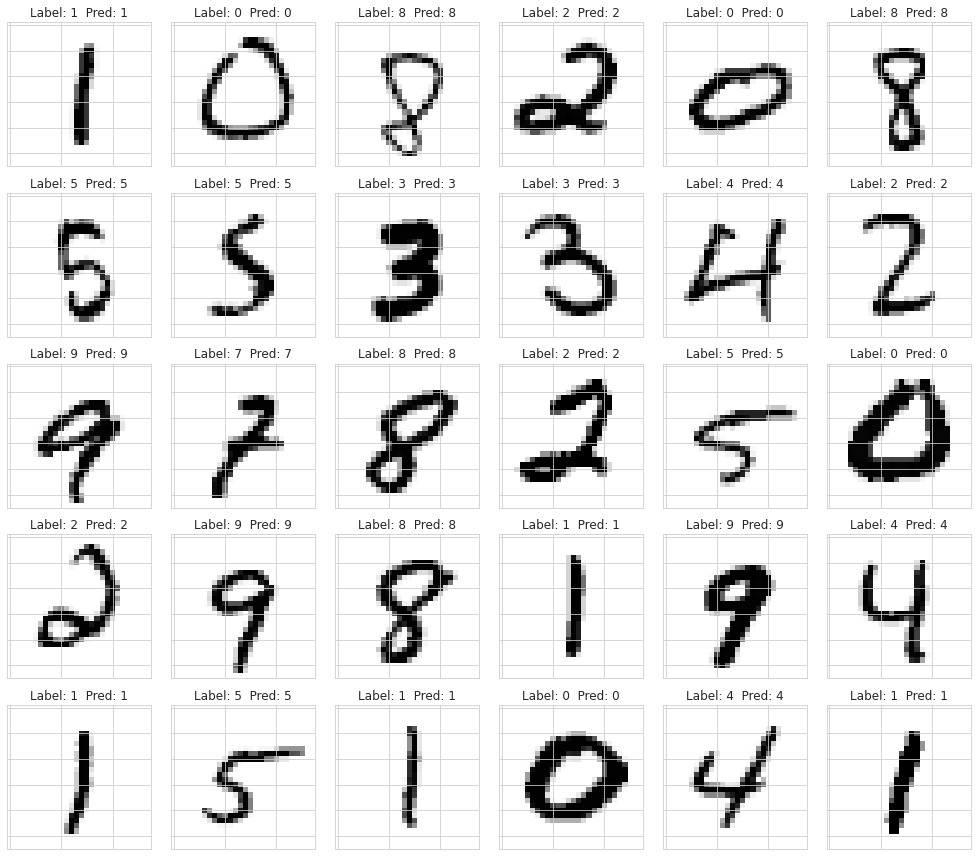

In [13]:
# retrieve sample of test images with predictions to plot
sample_test_df = predictions.sample(n=30)

# add image array to dataframe
sample_test_df['image'] = sample_test_df['image_path'].apply(plt.imread)

# plot test sample
plotDigitGrid(sample_test_df['image'], sample_test_df['label'], sample_test_df.index, y_hat=sample_test_df['label_predictions'])